### `jupyter notebook` for the `T-LSTM.py` example

Modified from the [`T-LSTM`](https://github.com/illidanlab/T-LSTM/blob/master/main_AE.py) repo

Import the required packages. Note that this notebook uses the autoencode example.

In [11]:
# A toy example for clustering with 2-layer TLSTM auto-encoder
# Inci M. Baytas, 2017
# How to run: Directly run the main file: python main_AE.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import h5py

from T_LSTM_AE import T_LSTM_AE

Take a quick look at the data set

In [12]:
cluster_data = h5py.File('../data/Clustering_Data_1D.mat')
print(list(cluster_data.keys()))

for item in cluster_data.keys():
    print(cluster_data[item])

[u'#refs#', u'Assign', u'Data', u'Time']
<HDF5 group "/#refs#" (16 members)>
<HDF5 dataset "Assign": shape (1, 5), type "|O">
<HDF5 dataset "Data": shape (1, 5), type "|O">
<HDF5 dataset "Time": shape (1, 5), type "|O">


Import the data set

In [13]:
# A synthetic data

Data = []
Time = []
Assignments = []
Target = []
with h5py.File("../data/Clustering_Data_1D.mat") as f:#
    for column in f['Data']:
        row_data = []
        for row_number in range(len(column)):
            row_data.append(f[column[row_number]][:])
    Data.append(row_data)
    for column in f['Time']:
        row_data = []
        for row_number in range(len(column)):
            row_data.append(f[column[row_number]][:])
    Time.append(row_data)
    for column in f['Assign']:
        row_data = []
        for row_number in range(len(column)):
            row_data.append(f[column[row_number]][:])
    Assignments.append(row_data)

cell_len = len(Data[0])

Investigate the data

In [14]:
print(type(Data)) # The data object is a list
print(len(Data))
#print(Data) 

<type 'list'>
1


Create a function to generate batches of data

In [15]:
def generate_batches(data, time, assign, index):
    batch_data = np.transpose(data[0][index])
    batch_time = np.transpose(time[0][index])
    batch_assign = np.transpose(assign[0][index])
    return batch_data, batch_time, batch_assign

Set model parameters

In [16]:
# set learning parameters
learning_rate = 1e-3
ae_iters = 2000 #Number of iterations (epochs)

# set network parameters
input_dim = np.size(Data[0][0], 0)
hidden_dim = 8
hidden_dim2 = 2
hidden_dim3 = 8
output_dim = hidden_dim
output_dim2 = hidden_dim2
output_dim3 = input_dim

Create the model, set the loss function, optimizer, and initialize

In [17]:
lstm_ae = T_LSTM_AE(input_dim, output_dim, output_dim2, output_dim3, hidden_dim, hidden_dim2, hidden_dim3)

loss_ae = lstm_ae.get_reconstruction_loss()

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss_ae)

init = tf.global_variables_initializer()

Run the model

In [18]:
with tf.Session() as sess:
    sess.run(init)
    Loss = np.zeros(ae_iters)
    for i in range(ae_iters):
        Ll = 0
        for j in range(cell_len):
            x, t, a = generate_batches(Data, Time, Assignments, j)
            _, L = sess.run([optimizer, loss_ae], feed_dict = {lstm_ae.input: x, lstm_ae.time: t})
            Ll += L
        Loss[i] = Ll / cell_len
        print('Loss: %f' %(Loss[i]))

    assign_truth = []
    data_reps = []
    for c in range(cell_len):
        data = np.transpose(Data[0][c])
        time = np.transpose(Time[0][c])
        assign = np.transpose(Assignments[0][c])
        reps, cells = sess.run(lstm_ae.get_representation(), feed_dict = {lstm_ae.input: data, lstm_ae.time: time})
        if c == 0:
            data_reps = reps
            assign_truth = assign
        else:
            data_reps = np.concatenate((data_reps, reps))
            assign_truth = np.concatenate((assign_truth, assign))

Loss: 324.265347
Loss: 323.876810
Loss: 323.489511
Loss: 323.098788
Loss: 322.699518
Loss: 322.286002
Loss: 321.852286
Loss: 321.389377
Loss: 320.883530
Loss: 320.354929
Loss: 319.812405
Loss: 319.232227
Loss: 318.602267
Loss: 317.914642
Loss: 317.159668
Loss: 316.324347
Loss: 315.393829
Loss: 314.351016
Loss: 313.177823
Loss: 311.854285
Loss: 310.365567
Loss: 308.715613
Loss: 306.913315
Loss: 304.974423
Loss: 302.939355
Loss: 300.828775
Loss: 298.678452
Loss: 296.509674
Loss: 294.340036
Loss: 292.181171
Loss: 290.035779
Loss: 287.903769
Loss: 285.796814
Loss: 283.705472
Loss: 281.595245
Loss: 279.398386
Loss: 277.425806
Loss: 275.566742
Loss: 273.746182
Loss: 271.956924
Loss: 270.228235
Loss: 268.533459
Loss: 266.871469
Loss: 265.246820
Loss: 263.656412
Loss: 262.098129
Loss: 260.571579
Loss: 259.077783
Loss: 257.614713
Loss: 256.181305
Loss: 254.776611
Loss: 253.399625
Loss: 252.049390
Loss: 250.724896
Loss: 249.425232
Loss: 248.149384
Loss: 246.897781
Loss: 245.669089
Loss: 244.4627

Loss: 70.174819
Loss: 69.986118
Loss: 69.821397
Loss: 69.664719
Loss: 69.502864
Loss: 69.324070
Loss: 69.131625
Loss: 68.983391
Loss: 68.831953
Loss: 68.676620
Loss: 68.485007
Loss: 68.299538
Loss: 68.172790
Loss: 68.032430
Loss: 67.862775
Loss: 67.650156
Loss: 67.520357
Loss: 67.396899
Loss: 67.223969
Loss: 67.010822
Loss: 66.833910
Loss: 66.729905
Loss: 66.575207
Loss: 66.360774
Loss: 66.182341
Loss: 66.081309
Loss: 65.910822
Loss: 65.700993
Loss: 65.533912
Loss: 65.425594
Loss: 65.250050
Loss: 65.055981
Loss: 64.902839
Loss: 64.783131
Loss: 64.611600
Loss: 64.428226
Loss: 64.279610
Loss: 64.154380
Loss: 63.989867
Loss: 63.808746
Loss: 63.662012
Loss: 63.541495
Loss: 63.380218
Loss: 63.195728
Loss: 63.051256
Loss: 62.939105
Loss: 62.781780
Loss: 62.590484
Loss: 62.446872
Loss: 62.346116
Loss: 62.196162
Loss: 61.995261
Loss: 61.848985
Loss: 61.759792
Loss: 61.623917
Loss: 61.411829
Loss: 61.257137
Loss: 61.179158
Loss: 61.061501
Loss: 60.836002
Loss: 60.671591
Loss: 60.602532
Loss: 60

Loss: 19.833032
Loss: 19.815223
Loss: 19.787827
Loss: 19.674654
Loss: 19.624359
Loss: 19.657311
Loss: 19.529139
Loss: 19.461316
Loss: 19.448704
Loss: 19.427154
Loss: 19.316565
Loss: 19.270588
Loss: 19.310323
Loss: 19.195494
Loss: 19.107721
Loss: 19.096976
Loss: 19.141780
Loss: 18.987467
Loss: 18.930242
Loss: 19.011513
Loss: 18.881527
Loss: 18.780822
Loss: 18.792074
Loss: 18.930016
Loss: 18.734465
Loss: 18.646983
Loss: 18.766396
Loss: 18.711847
Loss: 18.692476
Loss: 18.577180
Loss: 18.935591
Loss: 18.664779
Loss: 18.599885
Loss: 18.854764
Loss: 18.638968
Loss: 18.709585
Loss: 18.740004
Loss: 18.528700
Loss: 18.472680
Loss: 18.347241
Loss: 18.273594
Loss: 18.261537
Loss: 18.093150
Loss: 18.133060
Loss: 18.055681
Loss: 18.167420
Loss: 18.144112
Loss: 18.054111
Loss: 18.166515
Loss: 18.231954
Loss: 18.337565
Loss: 17.993457
Loss: 18.178904
Loss: 18.586174
Loss: 17.994789
Loss: 17.582200
Loss: 17.410738
Loss: 17.542606
Loss: 17.369831
Loss: 17.550809
Loss: 17.314902
Loss: 17.160320
Loss: 17

Loss: 6.375193
Loss: 6.388412
Loss: 6.388806
Loss: 6.355497
Loss: 6.391808
Loss: 6.370496
Loss: 6.333701
Loss: 6.386148
Loss: 6.358895
Loss: 6.326012
Loss: 6.416749
Loss: 6.368408
Loss: 6.325359
Loss: 6.458897
Loss: 6.368539
Loss: 6.289661
Loss: 6.371700
Loss: 6.301475
Loss: 6.227141
Loss: 6.218396
Loss: 6.188804
Loss: 6.182169
Loss: 6.189083
Loss: 6.151409
Loss: 6.175609
Loss: 6.176961
Loss: 6.129762
Loss: 6.182249
Loss: 6.172795
Loss: 6.115799
Loss: 6.211015
Loss: 6.183118
Loss: 6.111615
Loss: 6.262195
Loss: 6.190863
Loss: 6.088326
Loss: 6.214100
Loss: 6.142559
Loss: 6.045445
Loss: 6.067415
Loss: 6.031348
Loss: 5.990421
Loss: 5.992140
Loss: 5.974835
Loss: 5.951063
Loss: 5.952681
Loss: 5.940427
Loss: 5.921904
Loss: 5.921751
Loss: 5.913779
Loss: 5.889969
Loss: 5.889658
Loss: 5.896248
Loss: 5.870704
Loss: 5.856525
Loss: 5.881974
Loss: 5.914084
Loss: 5.841274
Loss: 5.923230
Loss: 5.990558
Loss: 6.046408
Loss: 5.936851
Loss: 5.889975
Loss: 6.402829
Loss: 6.209069
Loss: 6.470329
Loss: 6.25

Text(0.5,1,'TLSTM')

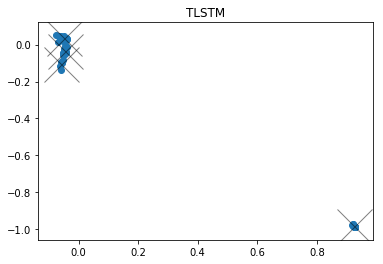

In [19]:
######## Clustering ##########################
kmeans = KMeans(n_clusters = 4, random_state = 0, init = 'k-means++').fit(data_reps)
centroid_values = kmeans.cluster_centers_

#plt.figure(1)
plt.scatter(data_reps[:, 0], data_reps[:, 1])
plt.plot(centroid_values[:, 0], centroid_values[:, 1], 'kx', markersize = 35, alpha = 0.5)
#, c = assign_truth, s = 50, I had to remove this code from the above line because it does not work in matplotlib 2.2.3
plt.title('TLSTM')
#plt.show()

In [ ]:
#print(assign_truth)